In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

## Scratch Logistic Regression 

In [25]:
class ScratchLogisticRegression():
    """
    Logistic regression scratch implementation

    Parameters
    ----------
    num_iter : int
      Number of iterations
    lr : float
      Learning rate
    no_bias : bool
      If no bias term is included True
    verbose : bool
      When outputting the learning process True

    Attributes
    ----------
    self.coef_ : The following form ndarray, shape (n_features,)
      Parameters
    self.loss : The following form ndarray, shape (self.iter,)
      Record losses on training data
    self.val_loss : The following form ndarray, shape (self.iter,)
      Record loss on validation data

    """
    def __init__(self, num_iter=50, lr=0.01, no_bias=False, C=1.0, verbose=False, debug=False):
        # Record hyperparameters as attributes
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.C = C
        self.verbose = verbose
        # Prepare an array to record the loss
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        
        # Debug data 
        self.debug = debug
        self.test_data = np.array([0.2, -0.3, 0.1]) 
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn logistic regression. If validation data is entered, the loss and accuracy for it are also calculated for each iteration.

        Parameters
        ----------
        X : The following form ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form ndarray, shape (n_samples, )
            Correct answer value of training data
        X_val : The following form ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form ndarray, shape (n_samples, )
            Correct value of verification data
        """
        
        # Whether to calculate validation data
        is_val_calc = (X_val is not None) and (y_val is not None)
        
        #Data preprocessing
        X, y  = self._data_processing(X, y)
        if is_val_calc:
            X_val, y_val  = self._data_processing(X_val, y_val)
        
        #Parameter θ is created according to the number of features
        if self.debug:
            self.coef_ = self.test_data
        else:
            self.coef_ = np.array(np.random.normal(0, 1, X.shape[1]))
        
        if self.debug:
            print("default theta:", self.coef_)
            print("default ploba:", self.predict_proba(X[:, 1:]).flatten())
            print()
        
        # Iterator number, repeat learning
        for i in range(self.iter):
            self._gradient_descent(X, y)
            self.loss[i] = self._loss(X, y)
            
            if is_val_calc:
                self.val_loss[i] = self._loss(X_val, y_val)
            
            if self.verbose:
                #Output the learning process when verbose is set to True
                print("iter: {}  coef:{}".format(i+1, self.coef_))
                print("probability:", self.predict_proba(X[:, 1:]).flatten())
                print("loss:", self.loss)
                print()
        pass

    def predict(self, X):
        """
        Estimate the label using logistic regression.

        Parameters
        ----------
        X : The following form ndarray, shape (n_samples, n_features)
            sample

        Returns
        -------
            The following form ndarray, shape (n_samples, 1)
            Estimated result by logistic regression
        """
        
        X, _ = self._data_processing(X)
        pred = self._logistic_hypothesis(X)
        pred = np.round(pred).astype(int).flatten()
        
        return pred
    
    def predict_proba(self, X):
        """
        Estimate the probability using logistic regression.

        Parameters
        ----------
        X : The following form ndarray, shape (n_samples, n_features)
            sample

        Returns
        -------
            The following form ndarray, shape (n_samples, 1)
            Estimated result by logistic regression
        """
        X, _ = self._data_processing(X)
        pred = self._logistic_hypothesis(X).flatten()
        
        return pred
    
    def _data_processing(self, X, y=None):
        # If the dataset is DataFrame, Series, convert to ndarray
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values
        
        # If the dataset is one-dimensional, convert it to two-dimensional
        if X.shape[0] == X.size:
            X = X.reshape(-1, 1)
        
        if y is not None:
            y = y.reshape(-1, 1)

        # Set the number of feature samples
        m = X.shape[0]
        
        # Addition of bias term
        if self.no_bias:
            n = X.shape[1]
        else:
            n = X.shape[1] + 1
            # Add the intercept (x = 1) to X
            X = np.concatenate((np.ones((m, 1)), X), axis=1)

        return X, y
    
    def _sigmoid(self, X):
        return 1 / (1 + np.exp(-X))
    
    def _logistic_hypothesis(self, X):
        linear_format = np.sum(self.coef_* X, axis=1).reshape(-1, 1)
        h_theta = self._sigmoid(linear_format)
        
        return h_theta
    
    def _gradient_descent(self, X, y):
        """
        Update the parameter θ in the gradient direction
        
         Parameters
        ----------
        X : The following form ndarray, shape (n_samples, n_features)
          Training data
        y : The following form ndarray, shape (n_samples, )
          Correct answer value of training data

        """
        m = len(X)
        
        grad = np.average(self._error(X, y) * X, axis=0)
        tmp = grad[0]
        
        grad = np.average(self._error(X, y) * X, axis=0) + (self.C * self.coef_ / m)
        grad[0] = tmp
        
        self.coef_ = self.coef_ - self.lr * grad
        
    def _error(self, X, y):
        """
        A function that calculates the error between the predicted value and the actual value

        Parameters
        ----------
        X : The following form ndarray, shape (n_samples, n_features)
          Training data
        y : The following form ndarray, shape (n_samples, )
            Correct answer value of training data
        
        Returns
        -------
          The following form ndarray, shape (n_samples, 1)
          Error between predicted value and actual value

        """
        return self._logistic_hypothesis(X) - y

    def _loss(self, X, y):
        """
        Calculate the loss function

         Parameters
        ----------
        X : The following form ndarray, shape (n_samples, n_features)
          Training data
        y : The following form ndarray, shape (n_samples, )
          Correct answer value of training data

        """

        m = len(X)
        start = 0 if self.no_bias else 1
        
        h_X = self._logistic_hypothesis(X)
        loss = np.average((-y * np.log(h_X)) - ((1 - y) * np.log(1 - h_X)))
        J_theta =  loss + self.C * np.sum(self.coef_[start:] ** 2) / (2 * m)

        if self.debug:
            print("loss", loss)
            print("J_theta:", J_theta)
        
        return J_theta


# Problem 1 

## Hypothetical Function

Implement the method of the logistic regression assumption function in the ScratchLogisticRegression class.

The logistic regression hypothetical function is the linear regression hypothetical function passed through his sigmoid function. The sigmoid function is expressed by the following formula.

$$g(z) = \frac{1}{1 + e Unknown Character Unknown Character Unknown Character ^ z}$$

The hypothetical function for linear regression was:

$$h_0(x) = 0^T . x$$ 

Putting it all together, the hypothetical function of logistic regression is as follows.

$$h_0(x) = \frac{1}{1 + e Unknown Character Unknown Character Unknown Character  0^T . x}$$

$ x $: Feature vector


$ 0 $: Parameter (weight) vector

# Problem 2 


## The Steepest Descent Method

Please implement to learn by the steepest descent method. Please add the method _gradient_descent of the parameter update expression expressed by the following expression and call it from the fit method.

$a$: Learning rate

$ i $: Sample index

$ j $: Feature index

$ m $: Number of data entered

$h_0()$: Hypothetical function

$ x $: Feature vector

$0$: Parameter (weight) vector

$x ^(i)$: Feature vector of i-th sample

$y^(i)$: Correct label for i-th sample

$0_j$: jth parameter (weight)

Unknown Character Unknown Character: Regularization parameters

# Problem 3 

## Estimate

Please implement the estimation mechanism. Add to the predict and predict_proba methods included in the template of the ScratchLogisticRegression class.

Hypothetical function $ hθ (x) $ The output of is the return value of predict_proba, and the value is labeled as 1 and 0 with a threshold value, which is the return value of predict.

# Problem 4 

## Objective Function

Implement the objective function (loss function) of logistic regression expressed by the following formula.

And be sure to record this in self.loss, self.val_loss.

Note that this formula contains a regularization term.

In [29]:
# Debug data
X_train = np.array([[-6, -4], 
             [2, 4],
             [6, 8]])

y_train = np.array([0, 1, 1])
X_test  = np.array([[3, 5],
                    [-4, 2]])


lr = ScratchLogisticRegression(num_iter=50, lr=0.01, C=2, verbose=True ,debug=True)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
pred_prob = lr.predict_proba(X_test)

print("pred:", pred)
print("pred_prob:", pred_prob)

default theta: [ 0.2 -0.3  0.1]
default ploba: [0.83202 0.5     0.31003]

loss 0.9812493147435388
J_theta: 1.0106406921347924
iter: 1  coef:[ 0.20119 -0.26423  0.13549]
probability: [0.77636 0.55347 0.4255 ]
loss: [1.01064 0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.     ]

loss 0.8010915698514743
J_theta: 0.8283149803176726
iter: 2  coef:[ 0.20201 -0.23247  0.16621]
probability: [0.71748 0.59915 0.53417]
loss: [1.01064 0.82831 0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.

# Problem 5 
## Learning and Estimation

Learn and estimate the scratch implementation for the virgicolor and virginica binary classifications of the iris dataset prepared in Sprint, an introduction to machine learning scratch.

Please check if it works properly compared to the implementation by scikit-learn.

Use scikit-learn for index values such as Accuracy, Precision, and Recall.

In [31]:
## Loading iris data
iris = load_iris()

## Select X1 (Petallength) and X2 (petalwidth) as features for learning.
train_x = iris.data[50:, 2:]
train_y = iris.target[50:]
train_y = np.array(list(map(lambda x: x-1, train_y)))

## Dividing into training data and test data
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, random_state=42)

## Standardization
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
## Hyperparameter settings
num_iter = 5000
alpha = 0.1
C = 1.0

## Define model
scratch_lr = ScratchLogisticRegression(num_iter=num_iter ,lr=alpha, C=C, verbose=False)
sklearn_lr = LogisticRegression()

model = {"scratch_LR": scratch_lr, "sklearn_LR": sklearn_lr}
results = pd.DataFrame(columns=["model_name", "accuracy_score", "precicion_score", "recall_score"])

## Learning and prediction
i = 0
for name, model in model.items():
    
    if name == "scratch_LR":
        model.fit(X_train, y_train, X_test, y_test)
    else:
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print(f"{name} predict:", y_pred)
    
    acc_score = accuracy_score(y_test, y_pred)
    pre_score = precision_score(y_test, y_pred)
    rec_score = recall_score(y_test, y_pred)
    
    results.loc[i, :] = [name, acc_score, pre_score, rec_score]
    i += 1

display(results)

scratch_LR predict: [0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0]
sklearn_LR predict: [0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0]


,model_name,accuracy_score,precicion_score,recall_score
0,scratch_LR,0.88,0.9,0.818182
1,sklearn_LR,0.88,0.9,0.818182


Since the same result was obtained, there seems to be no problem in implementation.

# Problem 6 

## Plot of Learning Curve

Look at the learning curve to see if the loss is falling properly.

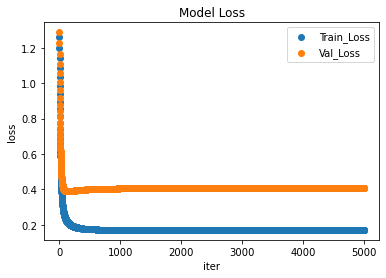

In [45]:
iter_list = list(range(num_iter))
scratch_train_loss = scratch_lr.loss
scratch_val_loss = scratch_lr.val_loss

plt.scatter(iter_list, scratch_train_loss, label="Train_Loss")
plt.scatter(iter_list, scratch_val_loss, label="Val_Loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("Model Loss")
plt.legend()
plt.show()

# Problem 7

## Visualization of Decision Area

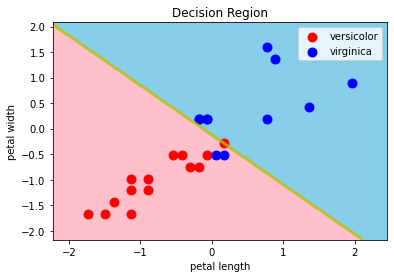

In [46]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='Decision Region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    Draw the determination area of the model that learned binary classification with two-dimensional features.
    The background color is drawn from the estimated values from the trained model.
    The points on the scatter plot are training or validation data.

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        Feature value
    y : ndarray, shape(n_samples,)
        label
    model : object
        Insert the installed model of the learned model
    step : float, (default : 0.1)
        Set the interval to calculate the estimate
    title : str
        Give the text of the graph title
    xlabel, ylabel : str
        Give the text of the axis label
    target_names= : list of str
        Give a list of legends
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

    
decision_region(X_test, y_test, scratch_lr, xlabel="petal length", ylabel="petal width")


# Problem 8 

## (Advance Task) Saving Weights

Let's make it possible to save and load the learned weights for easy verification. Use the pickle module and NumPy's np.savez.

In [47]:
import pickle
with open("model_pickle", "wb") as f:
    pickle.dump(model,f)

In [48]:
from tempfile import TemporaryFile

outfile = TemporaryFile()
np.savez(outfile, model)